In [2]:
import sys
import os
from typing import Dict, List
import warnings

import numpy as np
import loompy
import glob
import matplotlib.pyplot as plt
from pygenometracks import tracks

In [3]:
build = '/data/proj/scATAC/chromograph/build_20200623/Cerebellum'
peak_dir = os.path.join(build, 'peaks')
out_dir = os.path.join(build, 'exported')
f = os.path.join(build, 'Cerebellum_GA.loom')

100%|██████████| 100985/100985 [00:06<00:00, 16475.07it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


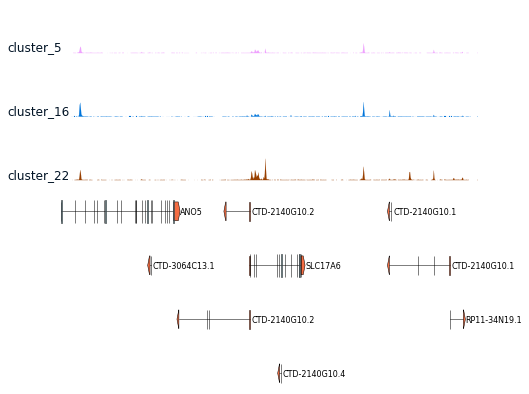

In [9]:
from cytograph.plotting.colors import colors75
from matplotlib.colors import to_hex
def plot_bigWig(ds: loompy.LoomConnection, gene, peak_dir, out_file, clusters: List[str] = None, padding = 10000):
    '''
    '''
    if clusters is None:
        ## Plot track for all clusters
        files = glob.glob(os.path.join(peak_dir, '*.bw'))
        ids = [int(f.split('_')[-1].split('.')[0]) for f in files]
        idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(ids))]
        files = [files[i] for i in idx]  
        
    else:
        ## Generate paths to requested clusters
        files = [os.path.join(peak_dir, f'cluster_{i}.bw') for i in clusters]

    bed_ref = '/home/camiel/gencode.basic.annotation.sort.bed12'
    height = len(files) * [1]
    height.append(4)
    fig, ax = plt.subplots(len(files)+1,1, figsize = (8,len(files)+4), gridspec_kw={'height_ratios': height})

    
    loc = ds.ra.loc[ds.ra.Gene == gene][0]
    chrom = loc.split(':')[0]
    start, end = [int(x) for x in loc.split(':')[1].split('-')]
    
    ## Add padding
    start = start - padding
    end = end + padding

    ## Plot each track
    for i, file in enumerate(files):
        title = file.split('/')[-1].split('.')[0]
        properties_dict = {'file': file, 'title': title, 'color':to_hex(colors75[i]), 'max_value': 10, 'alpha': 1}
        bw = tracks.BigWigTrack(properties_dict)

        bw.plot(ax[i], chrom, start, end)
        ax[i].text(-0.1, 0.01, title, verticalalignment='bottom', horizontalalignment='left', 
                   transform=ax[i].transAxes, color='#021426', fontsize=12)

        ## Aesthetics
        ax[i].axis("off")
        
    ## Plot gene reference
    properties_dict = {'file': bed_ref, 'title': 'Gencode', 'color': '#abd9e9', 'color_utr': '#f46d43', 'height_utr': .8, 'fontsize': 8, 
                       'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'flybase', 'labels': 'true',
                       'dpi': 144}
    gene = tracks.BedTrack(properties_dict)
    ax[-1].set_xlim(start, end)
    ax[-1].axis("off")
    gene.plot(ax[-1], chrom, start, end)

    plt.savefig(out_file)

with loompy.connect(f, 'r') as ds:
    gene = 'SLC17A6'
    subset = f.split('/')[-2]
    plot_bigWig(ds, gene, peak_dir, clusters = [5, 16, 22], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=150000)
#     plot_bigWig(ds, gene, peak_dir, clusters = [16, 12, 13, 1, 2, 10], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=50000)

#     plot_bigWig(ds, gene, peak_dir, clusters = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf')
#     plot_bigWig(ds, gene, peak_dir, out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf')

100%|██████████| 100985/100985 [00:06<00:00, 15779.12it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


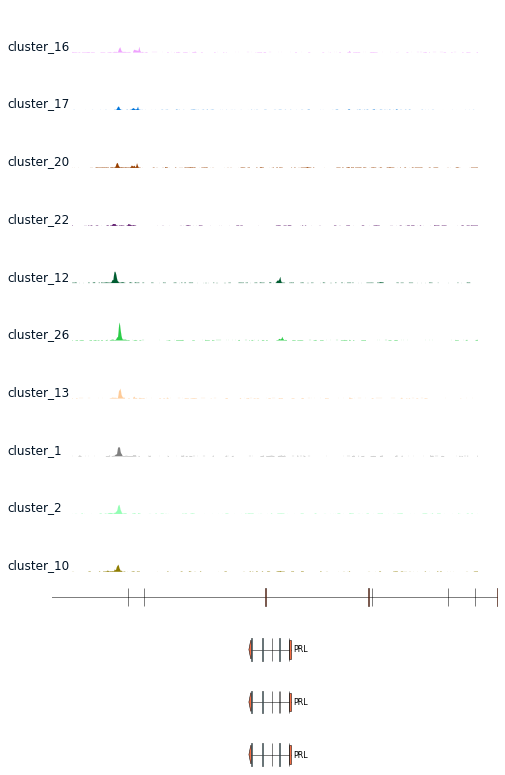

In [65]:
with loompy.connect(f, 'r') as ds:
    gene = 'PRL'
    subset = f.split('/')[-2]
    plot_bigWig(ds, gene, peak_dir, clusters = [16, 17, 20, 22, 12, 26, 13, 1, 2, 10], out_file= f'/home/camiel/misc/{subset}_{gene}_track.pdf', padding=50000)

100%|██████████| 100985/100985 [00:06<00:00, 14849.05it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 7.9799999999999995,-0.08


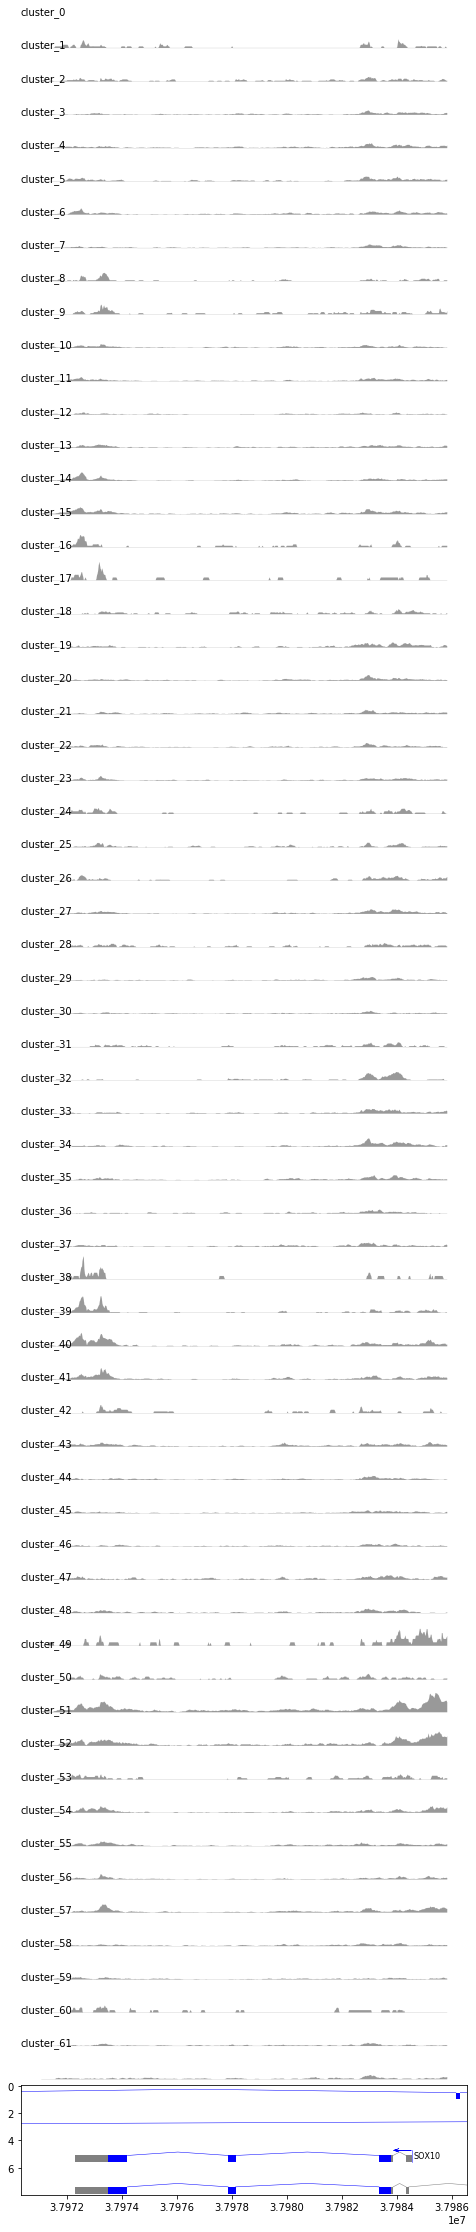

In [146]:
files = glob.glob(os.path.join(peak_dir, '*.bw'))
ids = [int(f.split('_')[-1].split('.')[0]) for f in files]
idx = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(ids))]
files = [files[i] for i in idx]

bed_ref = '/home/camiel/gencode.basic.annotation.sort.bed12'
height = len(files) * [1]
height.append(4)
fig, ax = plt.subplots(len(files)+1,1, figsize = (8,40), gridspec_kw={'height_ratios': height})

chrom = 'chr22'
start = 37970312
end = 37986555

## Plot each track
for i, file in enumerate(files):
    title = file.split('/')[-1].split('.')[0]
    properties_dict = {'file': file, 'height': 3, 'title': file.split('/')[-1].split('.')[0], 'color':'gray', 'max_value': 5, 'alpha': 0.8}
    bw = tracks.BigWigTrack(properties_dict)

#     ax[i].set_xlim(122747201, 122786077) 
    bw.plot(ax[i], chrom, start, end)
    ax[i].set_title(title, loc='left', fontsize=10)

    ## Aesthetics
    ax[i].axis("off")
    
## Plot gene reference
properties_dict = {'file': bed_ref, 'height': 10, 'title': 'Gencode', 'color': 'blue', 'fontsize': 8, 
                   'merge_transcripts': 'true', 'prefered_name': 'gene_name', 'style': 'tssarrow', 'labels': 'true'}
gene = tracks.BedTrack(properties_dict)
ax[-1].set_xlim(start, end)
gene.plot(ax[-1], chrom, start, end)

plt.savefig('test.pdf')

In [ ]:
# make a properties dict using as keys the values from the 
# documentation
properties_dict = {'file': <path to file>, 'height': 3, 'title'='bigwig', 'color'='red}

# initialize a bigwig track with the properties_dict. Any of the available tracks can be
# initialized in the same way
bw = BigWigTrack(properties_dict)

# to plot the region two axes are needed, one for the plot itself and the other for the legend.
figure, (track_ax, label_ax) = plt.subplots(1, 2)

# the plot method of all track classes expects 5 values, the track_ax, 
# the label_ax, and the genomic region to plot (chrom, start, end).
bw.plot(track_ax, label_ax, chrom, start, end)